In [2]:
import pandas as pd
import csv
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

In [3]:
project_root = os.path.dirname(os.getcwd())
data_path = os.path.join(project_root,'data')
raw_path = data_path + '/raw'
interim_path = data_path + '/interim/'

# Convert text to csv

In [ ]:
with open(raw_path+'/datos.txt', 'r') as in_file:
        stripped = (line.strip() for line in in_file)
        lines = (line.split(",") for line in stripped if line)
        with open(raw_path+'/datos.csv','w') as out_file:
            writer = csv.writer(out_file)
            writer.writerow(('id_person','activity','timestamp','x','y','z'))
            writer.writerows(lines)

# Preprocessing

In [ ]:
ts = 49105962326000
# Convert microseconds to seconds
date_time = datetime.fromtimestamp(ts / 1_000_000)
str_date_time = date_time.strftime("%d-%m-%Y, %H:%M:%S")
print("Result 1:", str_date_time)

str_date = date_time.strftime("%d %B, %Y")
print("Result 2:", str_date)

str_time = date_time.strftime("%I%p %M:%S")
print("Result 3:", str_time)

In [ ]:
def column_summary(df):
    summary_data = []
    
    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()
        
        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'distinct_values_counts': distinct_values_counts
        })
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df

In [ ]:
data = raw_path + '/datos.csv'
df = pd.read_csv(data)

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'] / 1_000_000, unit='s').dt.strftime("%d-%m-%Y, %H:%M:%S")

In [ ]:
summary_df = column_summary(df)
display(summary_df)

In [ ]:
df[df['z'].isnull()].index

In [ ]:
# ordenardo por persona,actividad y timestamp. Rellenar los nulos con la media 
df = df.sort_values(by=['id_person', 'activity', 'timestamp'])
df['z'] = df.groupby(['id_person', 'activity'])['z'].transform(lambda x: x.fillna(x.mean()))

In [ ]:
df

In [ ]:
df.info()

In [ ]:
df.to_csv(interim_path+'/datos.csv')

In [4]:
df = pd.read_csv(interim_path+'/datos.csv')

# EDA

## ACF

In [4]:
from statsmodels.tsa.stattools import adfuller

In [7]:
for axis in ['x', 'y', 'z']:
    serie = df[axis].dropna().values[:10000]  # Solo los primeros 10,000 datos
    result = adfuller(serie)
    print(f"--- ADF para {axis} ---")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")
    if result[1] < 0.05:
        print(f"La serie {axis} es estacionaria (rechaza H0)")
    else:
        print(f"La serie {axis} NO es estacionaria (no rechaza H0)")
    print()

--- ADF para x ---
ADF Statistic: -2.0973056208602134
p-value: 0.245599404269429
Critical Values: {'1%': np.float64(-3.431006330034765), '5%': np.float64(-2.861830058724424), '10%': np.float64(-2.566924393122448)}
La serie x NO es estacionaria (no rechaza H0)

--- ADF para y ---
ADF Statistic: -1.474682872878384
p-value: 0.5459961273701855
Critical Values: {'1%': np.float64(-3.4310064618089995), '5%': np.float64(-2.8618301169543403), '10%': np.float64(-2.5669244241183153)}
La serie y NO es estacionaria (no rechaza H0)

--- ADF para z ---
ADF Statistic: -11.837747416251458
p-value: 7.718552416406816e-22
Critical Values: {'1%': np.float64(-3.4310065936361585), '5%': np.float64(-2.861830175207641), '10%': np.float64(-2.5669244551266304)}
La serie z es estacionaria (rechaza H0)



## XYZ

In [ ]:
print(df[['x', 'y', 'z']].describe())

In [ ]:
sns.boxplot(data=df[['x', 'y', 'z']])

## xyz por activity

In [ ]:
df.groupby('activity')[['x', 'y', 'z']].mean().plot(kind='bar')

In [ ]:
df['magnitud'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)

In [ ]:
df

In [ ]:
print(df['activity'].value_counts()) 
sns.countplot(data=df, y='activity')

In [ ]:
df['z'][343419]

In [ ]:
# Identify numerical columns
numerical_columns = df.select_dtypes(include=[np.number]).columns

# Perform univariate analysis on numerical columns
for column in numerical_columns:
    # For continuous variables
    if len(df[column].unique()) > 10:  # Assuming if unique values > 10, consider it continuous
        plt.figure(figsize=(8, 6))
        sns.histplot(df[column], kde=True)
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()
    else:  # For discrete or ordinal variables
        plt.figure(figsize=(8, 6))
        ax = sns.countplot(x=column, data=df)
        plt.title(f'Count of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        
        # Annotate each bar with its count
        for p in ax.patches:
            ax.annotate(format(p.get_height(), '.0f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 5), 
                        textcoords = 'offset points')
        plt.show()

## Outliers

In [6]:
df

,Unnamed: 0,id_person,activity,timestamp,x,y,z
0,966746,1,Downstairs,"17-03-1970, 20:15:42",-0.15,9.15,-0.340000
1,966747,1,Downstairs,"17-03-1970, 20:16:32",0.11,9.19,2.760000
2,966748,1,Downstairs,"17-03-1970, 20:17:22",-4.06,7.40,4.020000
3,966749,1,Downstairs,"17-03-1970, 20:18:12",-2.87,7.93,3.210000
4,966750,1,Downstairs,"17-03-1970, 20:19:02",-0.19,10.04,4.820000
...,...,...,...,...,...,...,...
1098204,231259,36,Walking,"04-06-1970, 17:38:12",-2.22,6.32,5.434519
1098205,231260,36,Walking,"04-06-1970, 17:39:02",-3.06,5.71,6.088296
1098206,231261,36,Walking,"04-06-1970, 17:39:52",-3.49,5.83,5.788648
1098207,231262,36,Walking,"04-06-1970, 17:40:42",-4.14,6.21,5.938472


In [14]:
def find_and_plot_outleirs(df, column1, column2):
    Q1 = df[column1].quantile(0.25)
    Q3 = df[column1].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column1] < lower_bound) | (df[column1] > upper_bound)]
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=column1, y=column2, data=df)
    plt.title(f'Boxplot of {column1} vs {column2} with Outliers Highlighted')
    
    if not outliers.empty:
        sns.scatterplot(x=outliers[column1], y=outliers[column2], color='red', label='Outliers', s=100)    
    plt.xlabel(column1)
    plt.legend()
    plt.show()
    
    return outliers

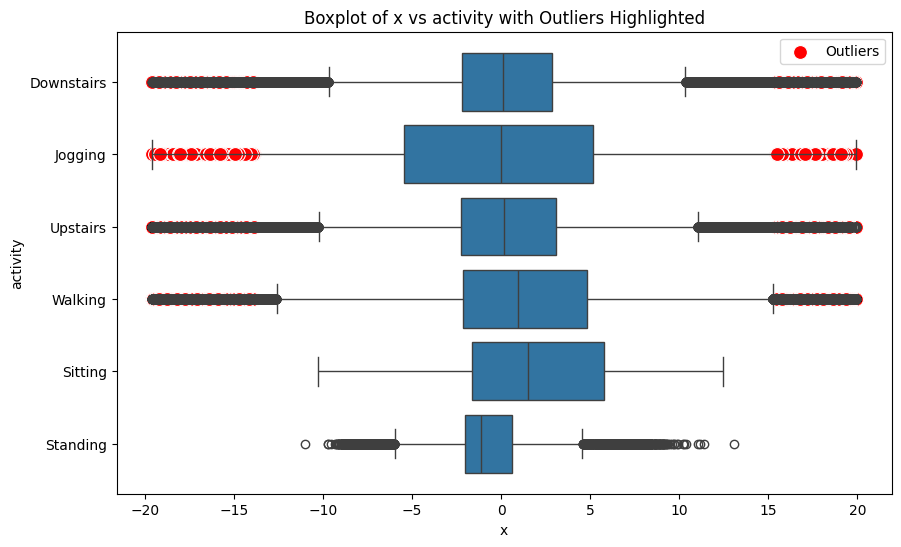

In [16]:
outliers_x = find_and_plot_outleirs(df, 'x', 'activity')

In [9]:
def plot_boxplot_activity(df, activity):
    plt.figure(figsize=(12, 6))
    # Filter the dataframe for the specified activity (case-insensitive)
    filtered_df = df[df['activity'].str.lower() == activity.lower()]
    # Select only the x, y, z columns
    data_to_plot = filtered_df[['x', 'y', 'z']]
    sns.boxplot(data=data_to_plot)
    plt.title(f'Boxplot of x, y, z for activity: {activity}')
    plt.xlabel('Axes')
    plt.ylabel('Values')
    plt.xticks(ticks=[0, 1, 2], labels=['x', 'y', 'z'])
    plt.show()

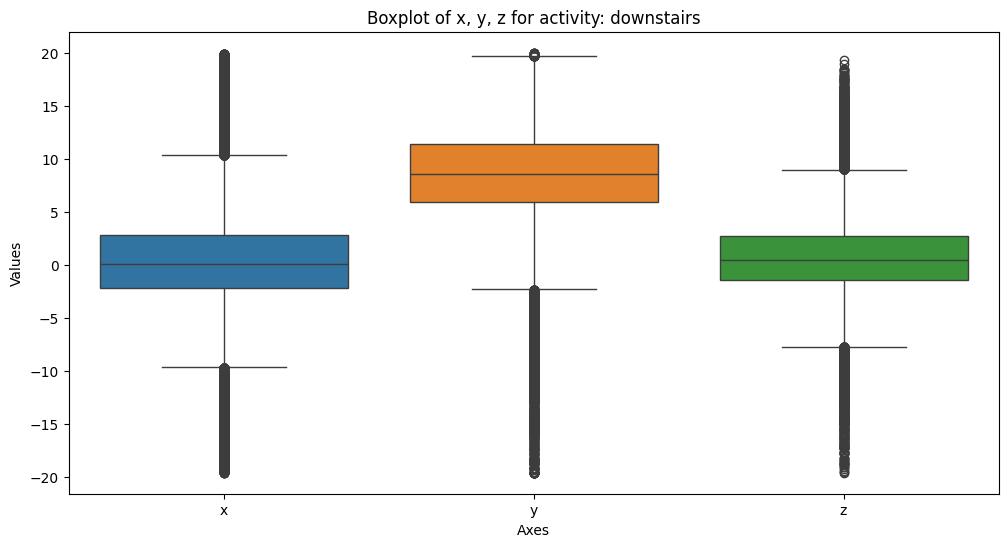

In [10]:
plot_boxplot_activity(df, 'downstairs')

In [ ]:
plot_boxplot_activity(df, 'jogging')

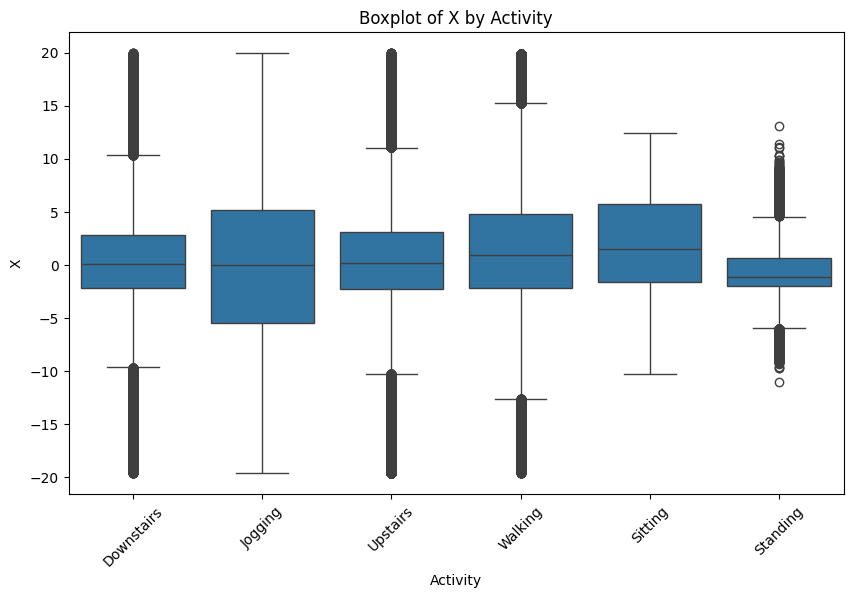

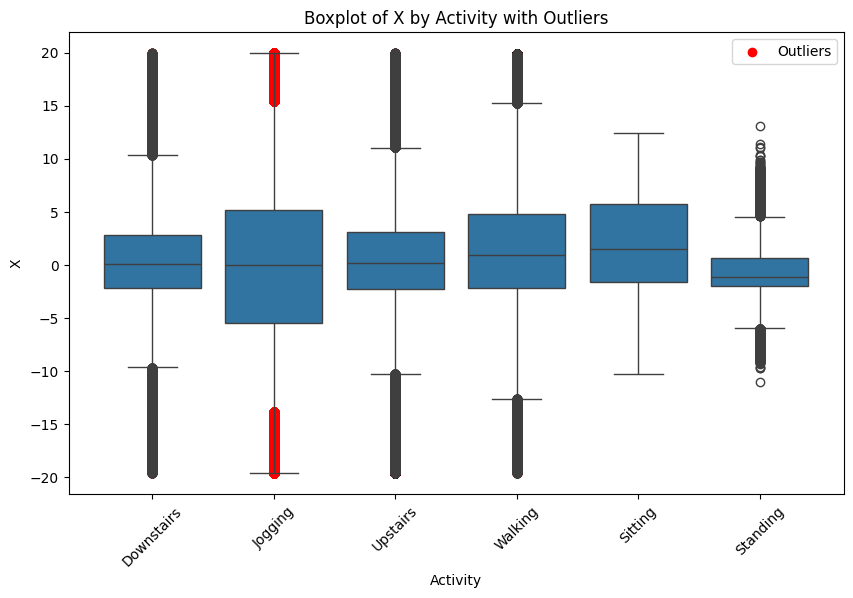

In [9]:
plt.figure(figsize=(10, 6))

# quiero hacer un boxplot de la columna 'x' segun la activity
sns.boxplot(x='activity', y='x', data=df)
plt.title('Boxplot of X by Activity')
plt.xlabel('Activity')
plt.ylabel('X')
plt.xticks(rotation=45)
plt.show()

# find outliers by quantiles
Q1 = df['x'].quantile(0.25)
Q3 = df['x'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['x'] < lower_bound) | (df['x'] > upper_bound)]
#print("Outliers in 'x':")
#print(outliers[['id_person', 'activity', 'x']])
# Plotting the outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='activity', y='x', data=df)
plt.scatter(outliers['activity'], outliers['x'], color='red', label='Outliers')
plt.title('Boxplot of X by Activity with Outliers')
plt.xlabel('Activity')
plt.ylabel('X')
plt.xticks(rotation=45)
plt.legend()
plt.show()
